<a href="https://colab.research.google.com/github/arvizu-god/dg-ssp/blob/main/DG_SSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installation of all necesarry pkgs
!pip install qiskit qiskit-aer
!pip install pylatexenc

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

In [4]:
class DGSSP:
    def __init__(self,s,t):
        """
        A small comment on the __init__ variables. We need to determine how many
        qubits we must use for encoding the integer set.
        n_sel: Variable that counts how many qubits we will use.
                One per element in s
        max_sum: Variable that stores the value of the sum of all elements in s.
        n_sum: Variable that stores how many qubits we will need for representing
                numbers from 0 to max_sum
        selector: QuantumRegister that stores whether each element of s has
                    already been on a subset.
        """
        self.s=s
        self.t=t
        self.n_sel=len(s)
        self.max_sum=sum(s)
        self.n_sum=math.ceil(math.log2(self.max_sum+1))
        self.qc=QuantumCircuit()

        #Calculate ancilla qubits for MCX gate
        compare_anc=max(0,(self.n_sum-1)-2)
        diffuser_anc=max(0,(self.n_sel-1)-2)
        self.anc_req=max(compare_anc,diffuser_anc)

        #Create registers
        self.selector=QuantumRegister(self.n_sel,name='sel')
        self.sum_reg=QuantumRegister(self.n_sum,name='sum')

        #Add necessary ancilla registers
        if self.anc_req>0:
            self.ancilla=QuantumRegister(self.anc_req,name='anc')
            self.qc=QuantumCircuit(self.selector,self.sum_reg,self.ancilla)

        else:
            self.ancilla=None
            self.qc=QuantumCircuit(self.selector,self.sum_reg)
        self.creg_sel=ClassicalRegister(self.n_sel,name='csel')
        self.qc.add_register(self.creg_sel)

    def draper_adder(self,control,a):
        """
        This function applies Draper's Adder to a register of qubits. It will is
        a controlled adder because it will add a constant 'a' to the sum register
        if the control qubit is |1>.

        Args:
            control: Variable that stores a |0> or a |1> to determine if the
                    element of s is in the subset.
            a: Element of s to be added
        Returns:
            qiskit.circuit.gate.Gate: Draper Adder operator represented as a gate.
        """
        n=self.n_sum
        self.qc.append(QFT(n,do_swaps=False).to_gate(label='QFT'),self.sum_reg)
        for i in range(n):
            angle=2*np.pi*a/(2**(i+1))
            self.qc.cp(angle,control,self.sum_reg[i])
        self.qc.append(QFT(n,do_swaps=False).inverse().to_gate(label='QFT†'),self.sum_reg)
    def draper_substractor(self,control,a):
        """
        This function applies Draper's substractor to obtain the original number
        after the oracle marked the state.
        """
        n=self.n_sum
        val=(-a)%(2**n)
        self.qc.append(QFT(n, do_swaps=False).to_gate(label="QFT"), self.sum_reg)
        for i in range(n):
            angle=2*np.pi*val/(2**(i+1))
            self.qc.cp(angle,control,self.sum_reg[i])
        self.qc.append(QFT(n, do_swaps=False).inverse().to_gate(label='QFT†'), self.sum_reg)
    def compare(self):
        n=self.n_sum
        t_bin=format(self.t,f'0{n}b')[::-1]
        for i, bit in enumerate(t_bin):
            if bit=='0':
                self.qc.x(self.sum_reg[i])
        if n>1:
            self.qc.h(self.sum_reg[-1])
            if self.ancilla is not None and len(self.ancilla)>= max(0, (n - 1) - 2):
                self.qc.mcx(self.sum_reg[:-1], self.sum_reg[-1],
                            ancilla_qubits=list(self.ancilla), mode='basic')
            else:
                self.qc.mcx(self.sum_reg[:-1], self.sum_reg[-1], mode='noancilla')
            self.qc.h(self.sum_reg[-1])
        else:
            self.qc.z(self.sum_reg[0])
        for i, bit in enumerate(t_bin):
            if bit == '0':
                self.qc.x(self.sum_reg[i])
    def grover_diffuser(self):
        self.qc.h(self.selector)
        self.qc.x(self.selector)
        if self.n_sel > 1:
            self.qc.h(self.selector[-1])
            if self.ancilla is not None and len(self.ancilla) >= max(0, (self.n_sel - 1) - 2):
                self.qc.mcx(self.selector[:-1], self.selector[-1],
                            ancilla_qubits=list(self.ancilla), mode='basic')
            else:
                self.qc.mcx(self.selector[:-1], self.selector[-1], mode='noancilla')
            self.qc.h(self.selector[-1])
        else:
            self.qc.z(self.selector[0])
        self.qc.x(self.selector)
        self.qc.h(self.selector)

    def build_circuit(self):
        self.qc.h(self.selector)
        r = max(1, int(np.floor(np.pi / 4 * np.sqrt(2 ** self.n_sel))))
        for _ in range(r):
            for i, a in enumerate(self.s):
                self.draper_adder(self.selector[i], a)
            self.compare()
            for i, a in reversed(list(enumerate(self.s))):
                self.draper_substractor(self.selector[i], a)
            self.grover_diffuser()
        self.qc.measure(self.selector, self.creg_sel)
        return self.qc

In [5]:
class DGSSP_results:
    def __init__(self,qc,s):
        self.qc=qc
        self.s=s
    def simulate(self,shots=2048) -> dict:
        #qc.measure_all()
        simulator=AerSimulator()
        tqc=transpile(self.qc,simulator)
        result=simulator.run(tqc).result()
        counts=result.get_counts()
        return counts
    def decode(self, counts: dict) -> dict:
        decoded = {}
        for bitstring, count in counts.items():
            # Reverse the bitstring so that the rightmost bit corresponds to S[0].
            bits = bitstring[::-1]
            subset = [self.s[i] for i, bit in enumerate(bits) if bit == '1']
            subset_str = str(subset)
            decoded[subset_str] = count
        # Sort the dictionary by counts (highest count first)
        sorted_decoded = dict(sorted(decoded.items(), key=lambda x: x[1], reverse=True))
        return sorted_decoded

    def plot_histogram(self, decoded_counts: dict):
        # Extract the keys and values (they're already sorted).
        subsets = list(decoded_counts.keys())
        counts_values = list(decoded_counts.values())

        # Convert subset tuples to string labels.
        subset_labels = [str(subset) for subset in subsets]

        plt.figure(figsize=(10, 6))
        plt.bar(subset_labels, counts_values, color='blue')
        plt.xlabel("Subset of S")
        plt.ylabel("Counts")
        plt.title("Histogram of Measured Subsets (Noise-Free)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

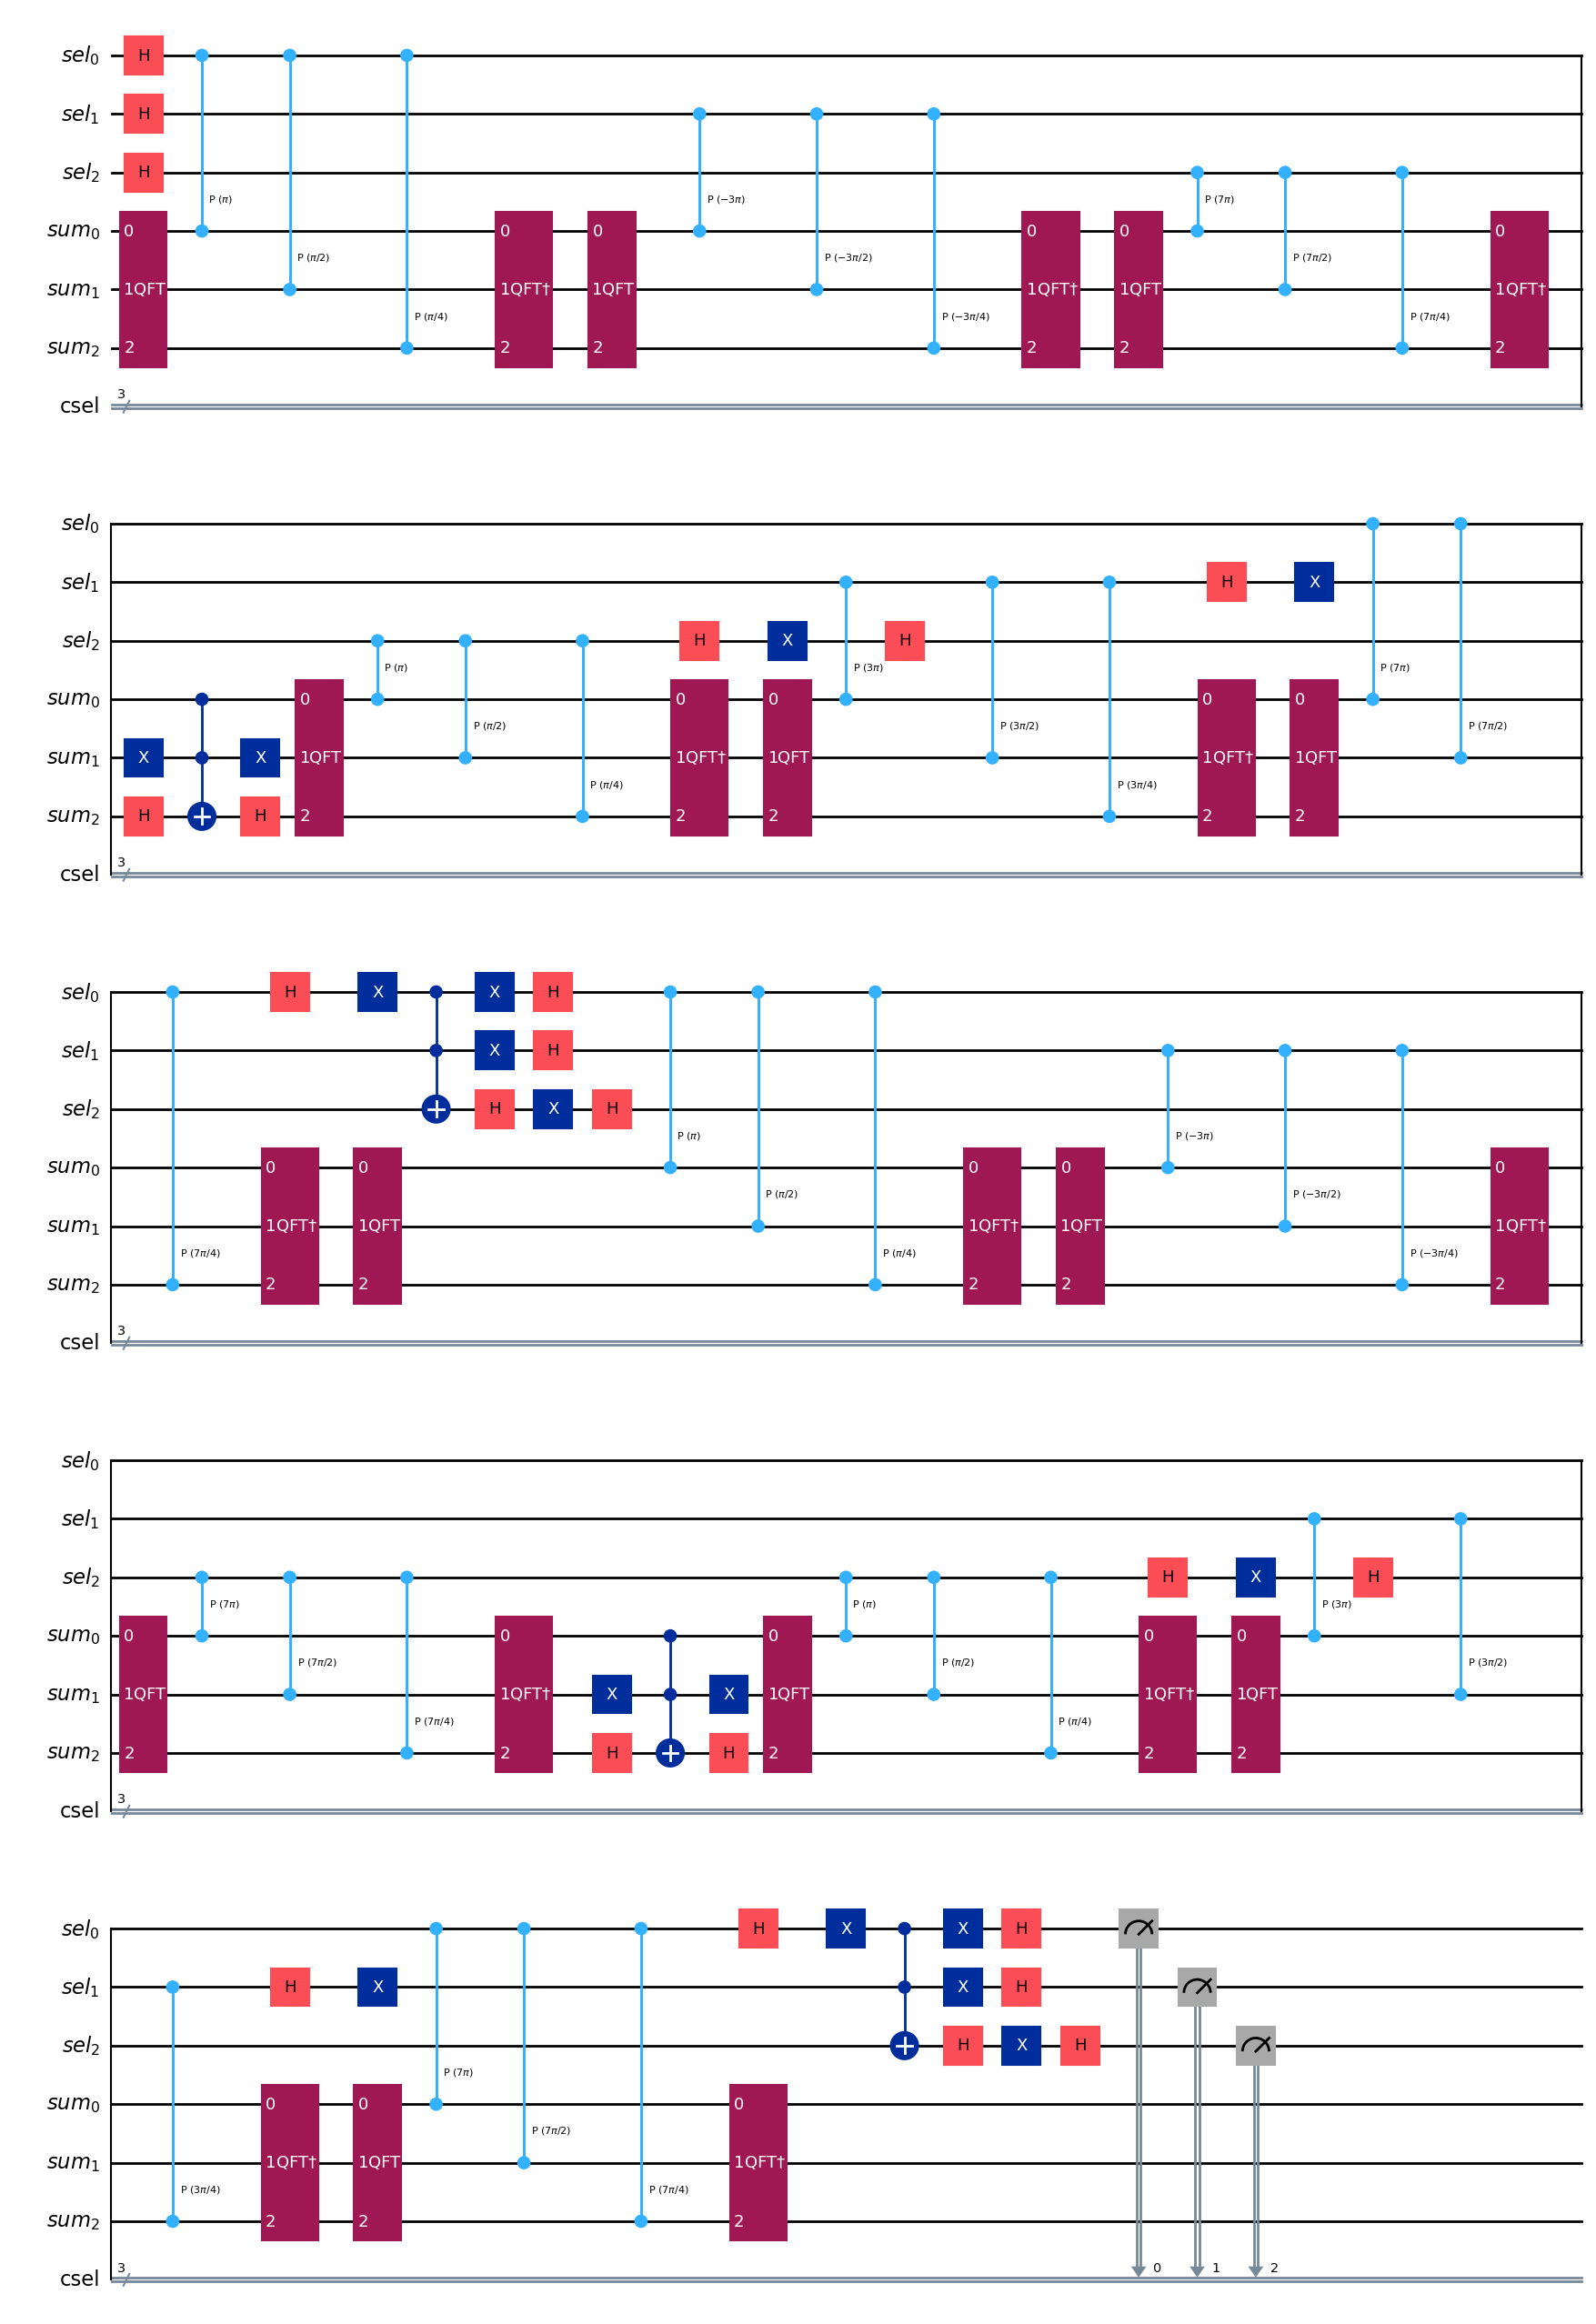

In [10]:
s=[1, -3, 7]
t=5
dgssp=DGSSP(s,t)
qc=dgssp.build_circuit()
qc.draw('mpl')

{'[-3, 7]': 146, '[]': 139, '[1, -3, 7]': 132, '[7]': 131, '[1, -3]': 123, '[-3]': 120, '[1, 7]': 117, '[1]': 116}


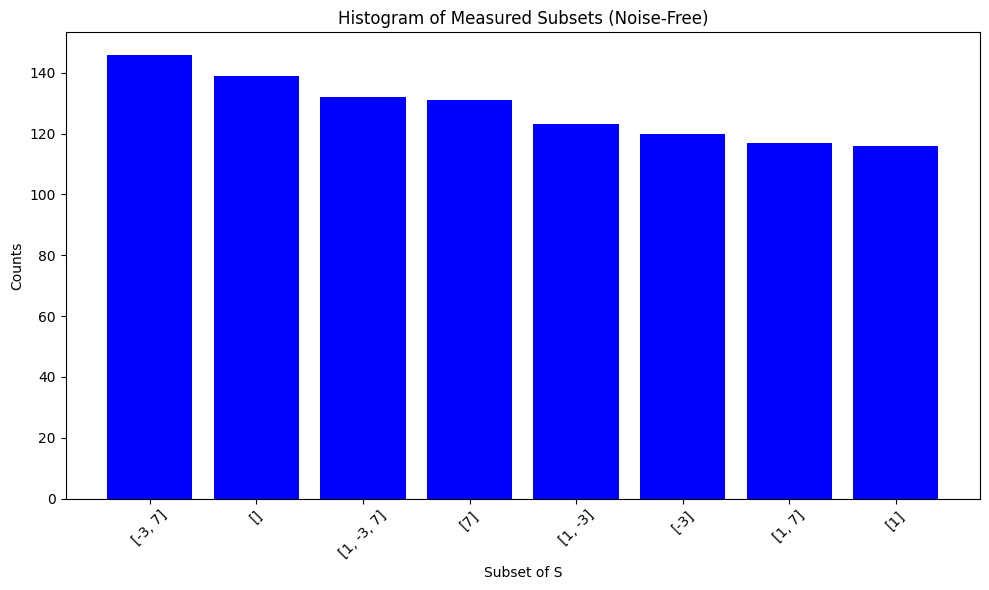

In [11]:
#Results for qc circuit
qc1=qc.copy()
r1=DGSSP_results(qc1,s)
v1=r1.simulate()
v2=r1.decode(v1)
print(v2)
r1.plot_histogram(v2)

{'[3, 11]': 119, '[1, 11]': 124, '[]': 137, '[3]': 116, '[1]': 125, '[11]': 120, '[1, 3]': 140, '[1, 3, 11]': 143}


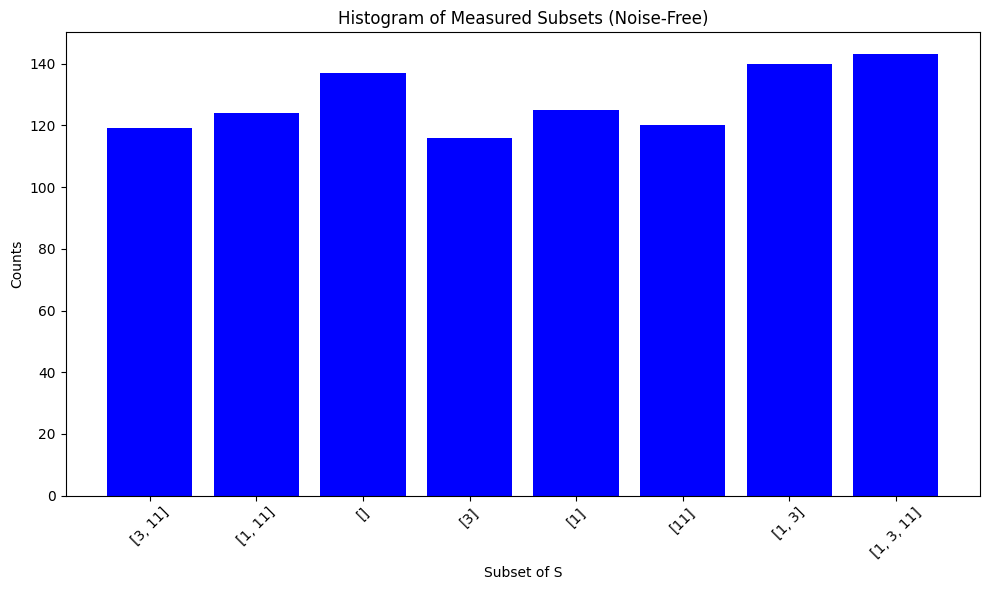

In [18]:
#Results for qc circuit
qc2=qc.copy()
r2=DGSSP_results(qc2,s)
v2=r2.simulate()
v2_2=r1.decode(v2)
print(v2_2)
r1.plot_histogram(v2_2)